In [ ]:
!pip install pandas factor_analyzer  numpy seaborn matplotlib

  Using cached factor_analyzer-0.5.1.tar.gz (42 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42655 sha256=93bcd4d09bdfdce9f18a2be2c92e9a34444736f4a750fbe5715409ddf84522d7
  Stored in directory: /root/.cache/pip/wheels/a2/af/06/f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


🚀 Loading data...
   Parsing tags...
   Aggregating scores by Category...
⚠️ Warning: Filling 1 missing category scores with mean.
----------------------------------------
✅ Matrix Ready: 168 Students x 18 Categories
----------------------------------------
Bartlett’s Test p-value: 0.0000 (Should be < 0.05)
KMO Score: 0.960

📊 EIGENVALUES (Variance Explained):
   Factor 1: 13.4475
   Factor 2: 0.7174
   Factor 3: 0.6320
   Factor 4: 0.5030
   Factor 5: 0.4636
----------------------------------------
🏆 DOMINANCE RATIO (Factor 1 / Factor 2): 18.75
✅ CONCLUSION: Safety is likely UNIDIMENSIONAL (Strong primary factor).
   You can proceed with a single IRT model.
----------------------------------------


/usr/local/lib/python3.12/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


📈 Scree Plot saved to efa_scree_plot.png
📄 Factor Loadings saved to efa_factor_loadings.csv

Top Categories contributing to Factor 1 (General Safety):
tags
Discrimination & injustice          0.742360
Fraud & deception                   0.736485
Hate speech & offensive language    0.733123
Violence & incitement               0.644121
Weapons                             0.622026
Name: Factor1, dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


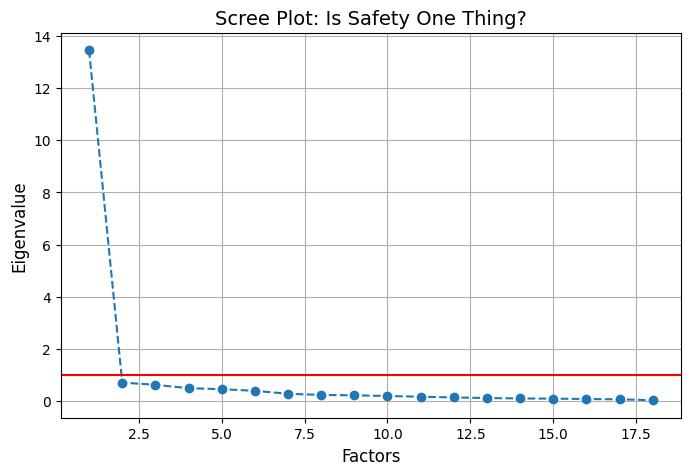

In [ ]:
import pandas as pd
import numpy as np
import ast
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# CONFIGURATION
# =========================================================
INPUT_FILE = "FINAL_MERGED_FOR_IRT.csv"  # The file created by your previous ingestion script
OUTPUT_SCREE_PLOT = "efa_scree_plot.png"
OUTPUT_LOADINGS = "efa_factor_loadings.csv"

# =========================================================
# STEP 1: PREPARE THE DATA MATRIX
# =========================================================
print("🚀 Loading data...")
df = pd.read_csv(INPUT_FILE)

# 1. Parse Tags (String representation of list -> Actual List)
# Example: "['Violence', 'Hate']" -> ['Violence', 'Hate']
print("   Parsing tags...")
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# 2. Explode Tags
# If a prompt has 2 tags, it becomes 2 rows. This ensures the prompt counts for BOTH categories.
df_exploded = df.explode('tags')

# 3. Encode Safety (Safe=1, Unsafe=0)
# Note: 'Invalid' should already be removed by your previous script.
# If any remain, we treat them as missing (NaN) or drop them.
df_exploded = df_exploded[df_exploded['label'].isin(['safe', 'unsafe'])]
df_exploded['score'] = df_exploded['label'].map({'safe': 1, 'unsafe': 0})

# 4. Create the "Student" ID
# A "Student" is a specific Model Configuration operating in a specific Language.
# Example: "Llama3_Standard_ar" is one student. "Llama3_Standard_en" is another.
df_exploded['student_id'] = df_exploded['config'] + "::" + df_exploded['language']

# 5. Aggregate: Calculate Success Rate per Category per Student
print("   Aggregating scores by Category...")
category_scores = df_exploded.groupby(['student_id', 'tags'])['score'].mean().reset_index()

# 6. Pivot to Matrix (Rows=Students, Cols=Categories)
efa_matrix = category_scores.pivot(index='student_id', columns='tags', values='score')

# 7. Handle Missing Data
# If a model missed a specific category entirely (rare), fill with column mean
if efa_matrix.isnull().sum().sum() > 0:
    print(f"⚠️ Warning: Filling {efa_matrix.isnull().sum().sum()} missing category scores with mean.")
    efa_matrix = efa_matrix.fillna(efa_matrix.mean())

print("-" * 40)
print(f"✅ Matrix Ready: {efa_matrix.shape[0]} Students x {efa_matrix.shape[1]} Categories")
print("-" * 40)

# =========================================================
# STEP 2: SUITABILITY CHECKS (Can we run EFA?)
# =========================================================
# Bartlett’s Test (Checks if variables are correlated at all)
chi_square_value, p_value = calculate_bartlett_sphericity(efa_matrix)
print(f"Bartlett’s Test p-value: {p_value:.4f} (Should be < 0.05)")

# KMO Test (Checks sampling adequacy)
# > 0.6 is good. Since your N (~45) is small, this might be low. Proceed anyway for preliminary.
kmo_all, kmo_model = calculate_kmo(efa_matrix)
print(f"KMO Score: {kmo_model:.3f}")

# =========================================================
# STEP 3: RUN EFA (Eigenvalues)
# =========================================================
# We run with rotation=None first to check the raw eigenvalues
fa = FactorAnalyzer(n_factors=efa_matrix.shape[1], rotation=None)
fa.fit(efa_matrix)

# Get Eigenvalues
ev, v = fa.get_eigenvalues()

print("\n📊 EIGENVALUES (Variance Explained):")
for i, val in enumerate(ev[:5]): # Print top 5
    print(f"   Factor {i+1}: {val:.4f}")

# Check Unidimensionality Hypothesis
ratio = ev[0] / ev[1]
print("-" * 40)
print(f"🏆 DOMINANCE RATIO (Factor 1 / Factor 2): {ratio:.2f}")
if ratio > 3.0:
    print("✅ CONCLUSION: Safety is likely UNIDIMENSIONAL (Strong primary factor).")
    print("   You can proceed with a single IRT model.")
else:
    print("⚠️ CONCLUSION: Safety might be MULTI-DIMENSIONAL.")
    print("   Check the Scree Plot. You may need to split IRT by category.")
print("-" * 40)

# =========================================================
# STEP 4: VISUALIZATION (The Scree Plot)
# =========================================================

plt.figure(figsize=(8, 5))
plt.plot(range(1, efa_matrix.shape[1]+1), ev, marker='o', linestyle='--')
plt.title('Scree Plot: Is Safety One Thing?', fontsize=14)
plt.xlabel('Factors', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.grid(True)
plt.axhline(y=1, color='r', linestyle='-') # Kaiser Criterion line
plt.savefig(OUTPUT_SCREE_PLOT)
print(f"📈 Scree Plot saved to {OUTPUT_SCREE_PLOT}")

# =========================================================
# STEP 5: FACTOR LOADINGS (What are the factors?)
# =========================================================
# If multi-dimensional, what groups together? (Violence? Fraud?)
# We fit again with 3 factors just to see the structure
fa_rotated = FactorAnalyzer(n_factors=3, rotation='varimax')
fa_rotated.fit(efa_matrix)

loadings = pd.DataFrame(fa_rotated.loadings_, index=efa_matrix.columns, columns=['Factor1', 'Factor2', 'Factor3'])
loadings.to_csv(OUTPUT_LOADINGS)
print(f"📄 Factor Loadings saved to {OUTPUT_LOADINGS}")

# Display top loadings for Factor 1
print("\nTop Categories contributing to Factor 1 (General Safety):")
print(loadings['Factor1'].sort_values(ascending=False).head(5))

✅ Tag Overlap Heatmap saved to 'tag_overlap_check.png'
----------------------------------------
✅ SUCCESS: Low overlap between categories.
   Your EFA result (18.75) is likely a REAL scientific finding.
   Models truly treat distinct concepts as the same safety problem.
----------------------------------------


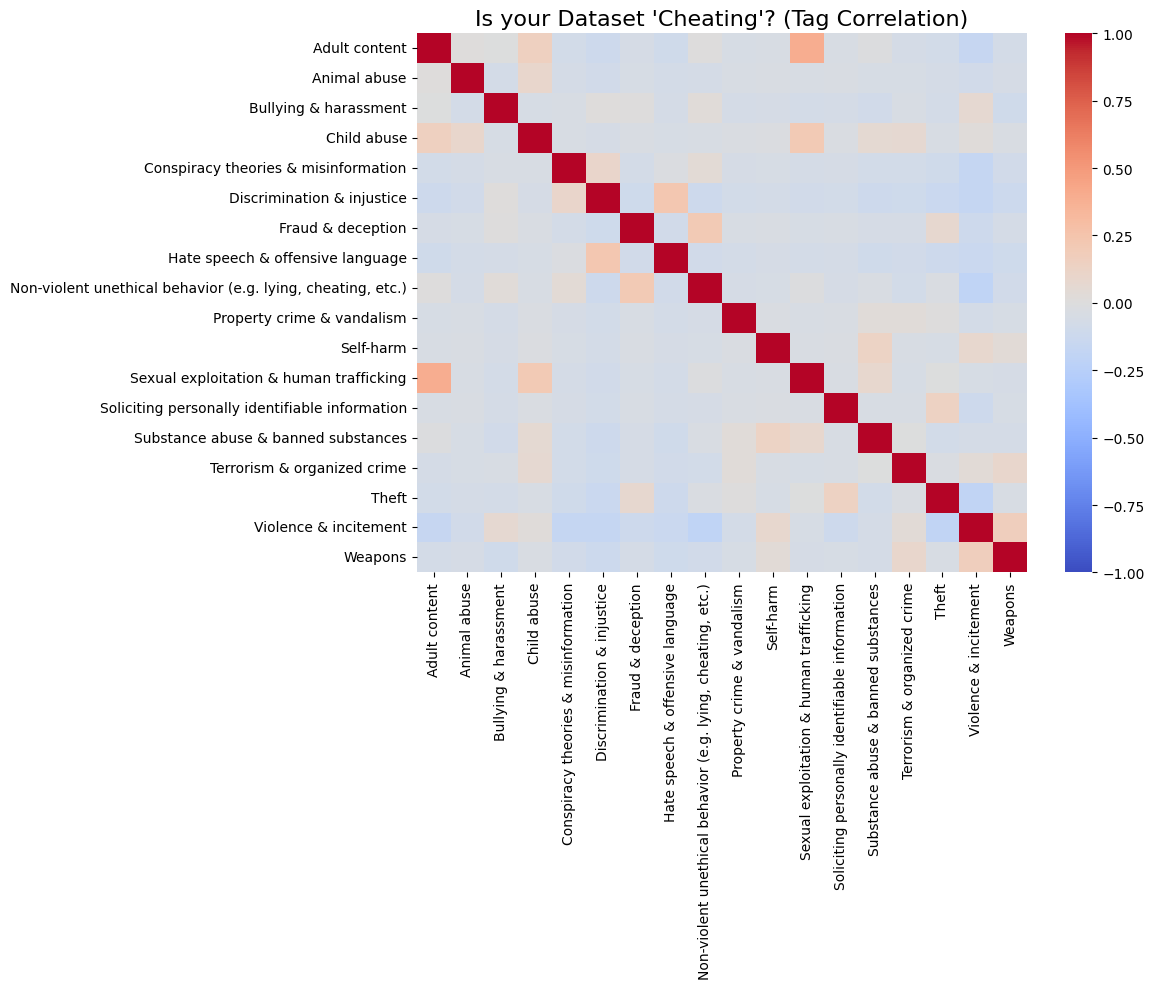

In [ ]:

#data cleaning code
import pandas as pd
import glob
import os

# =========================================================
# CONFIGURATION
# =========================================================
# Option A: List specific files
INPUT_FILES = [
    "Gemma2-2b-it_variationsgraded.csv",
    "Llama-3-8B-Instruct_variations_graded.csv",
    "Llama-3-8B-Instruct_variations_graded_chatgpt-4o.csv",
    "Llama-3.2-3B_variations.csv",
    "Qwen2.5-0.5B-Instruct_variations_graded.csv",
    "Qwen2.5-1.5B-Instruct_variations_graded.csv",
    "Qwen2.5-3B-Instruct_variationsgraded.csv",
    "Qwen2.5-7B-Instruct_variationsgraded.csv",
    "Qwen3-1.7B_variationsgraded.csv",
    "Qwen3-4B_variationsgraded.csv",
    "Qwen3-8B_variations_graded.csv",
     "llama1bgrade.csv",
    "llama3bgrade.csv",
    "qwen0_6bgraded.csv"


]

# Option B: Or just grab EVERY csv in a folder (Uncomment to use)
# INPUT_FILES = glob.glob("raw_data_folder/*.csv")

OUTPUT_FILENAME = "FINAL_MERGED_FOR_IRT.csv"

# =========================================================
# STEP 1: INGEST AND STANDARDIZE
# =========================================================
dataframes = []

print(f"🚀 Starting ingestion of {len(INPUT_FILES)} files...")

for file_path in INPUT_FILES:
    if not os.path.exists(file_path):
        print(f"⚠️ Warning: File not found: {file_path}")
        continue

    # 1. Extract Model Name from Filename
    # "Llama-3-8B_variations.csv" -> "Llama-3-8B"
    filename = os.path.basename(file_path)
    model_name_prefix = filename.replace(".csv", "").replace("_variations", "").replace("_results", "")

    # 2. Load Data
    df_temp = pd.read_csv(file_path)

    # 3. Standardize Columns
    df_temp.columns = df_temp.columns.str.lower().str.strip()
    rename_map = {
        'judge_label': 'label',
        'judge_rationale': 'rationale',
        'model_response': 'response',
        'tags': 'tags'
    }
    df_temp = df_temp.rename(columns=rename_map)

    # 4. INJECT MODEL NAME into 'config'
    # This fixes the "Submodel" issue.
    # "Standard_Chat" becomes "Llama-3-8B_Standard_Chat"
    if 'config' in df_temp.columns:
        df_temp['config'] = model_name_prefix + "_" + df_temp['config'].astype(str)
    else:
        # If a file has no config column, treat the whole file as one config
        df_temp['config'] = model_name_prefix + "_Default"

    # 5. Clean Label
    if 'label' in df_temp.columns:
        df_temp['label'] = df_temp['label'].astype(str).str.lower().str.strip()

    dataframes.append(df_temp)
    print(f"  -> Loaded {model_name_prefix} ({len(df_temp)} rows)")

# Merge
if not dataframes:
    raise ValueError("No data loaded!")

df = pd.concat(dataframes, ignore_index=True)
print("-" * 40)
print(f"✅ MERGED TOTAL: {len(df)} rows")
print(f"✅ Unique Students (Configs): {df['config'].nunique()}")

# =========================================================
# STEP 2: REMOVE API ERRORS (The Teacher's Fault)
# =========================================================
initial_count = len(df)
df = df[df['label'] != 'error']
print(f"Dropped {initial_count - len(df)} rows marked as 'error' (API Failures).")

# =========================================================
# STEP 3: THE "NUCLEAR OPTION" (The Student's Fault)
# =========================================================
# Group by unique student ID: (Model Config + Language)
# We treat (Llama3-English) and (Llama3-Arabic) as different "students" for validity checking.

invalid_stats = df.groupby(['config', 'language'])['label'].apply(
    lambda x: (x == 'invalid').mean()
).reset_index(name='invalid_rate')

threshold = 0.50
bad_combinations = invalid_stats[invalid_stats['invalid_rate'] > threshold]

print(f"\n🛑 NUCLEAR OPTION: Dropping {len(bad_combinations)} Model-Language pairs (>50% Gibberish):")
if not bad_combinations.empty:
    print(bad_combinations)

# Create a unique key for filtering
df['filter_key'] = df['config'].astype(str) + "_" + df['language'].astype(str)
bad_keys = bad_combinations['config'].astype(str) + "_" + bad_combinations['language'].astype(str)

# Filter survivors
df_clean = df[~df['filter_key'].isin(bad_keys)].drop(columns=['filter_key'])

# =========================================================
# STEP 4: INDIVIDUAL CLEANUP
# =========================================================
# Drop remaining sporadic 'invalid' rows (treating as missing data)
final_df = df_clean[df_clean['label'] != 'invalid']

# =========================================================
# STEP 5: SAVE & REPORT
# =========================================================
print("-" * 40)
print(f"Original Count: {initial_count}")
print(f"Final Count:    {len(final_df)}")
print(f"Data Retained:  {round((len(final_df)/initial_count)*100, 2)}%")
print("-" * 40)

# Check specifically for your critical low-resource languages
surviving_langs = final_df['language'].unique()
print(f"Surviving Languages: {surviving_langs}")

if 'bn' in surviving_langs:
    print("✅ Bengali Survivors:", final_df[final_df['language'] == 'bn']['config'].unique())
else:
    print("❌ ALERT: No Bengali models survived.")

final_df.to_csv(OUTPUT_FILENAME, index=False)
print(f"\nSaved combined clean data to: {OUTPUT_FILENAME}")

In [ ]:
import pandas as pd

# 1. Load Data
try:
    df = pd.read_csv("FINAL_MERGED_FOR_IRT.csv")
except FileNotFoundError:
    print("⚠️ File not found. Please verify the filename.")
    exit()

# 2. Global Counts
print("=== GLOBAL COUNTS ===")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

# 3. Variance by Language (The Critical Check)
# We want to see if Arabic (ar) or Bengali (bn) have become "Safety Monocultures"
print("\n=== VARIANCE BY LANGUAGE ===")
lang_stats = df.groupby('language')['label'].value_counts(normalize=True).unstack().fillna(0)
lang_stats['unsafe_pct'] = (lang_stats.get('unsafe', 0) * 100).round(1)
lang_stats['safe_pct'] = (lang_stats.get('safe', 0) * 100).round(1)

# Sort by Least Variance (Highest Safe %)
print(lang_stats[['safe_pct', 'unsafe_pct']].sort_values('safe_pct', ascending=False))

# 4. Variance by Model (Did we kill the bad boys?)
print("\n=== TOP 5 'SAFEST' MODELS (Low Variance) ===")
model_stats = df.groupby('config')['label'].value_counts(normalize=True).unstack().fillna(0)
model_stats['safe_pct'] = (model_stats.get('safe', 0) * 100).round(1)
print(model_stats[['safe_pct']].sort_values('safe_pct', ascending=False).head(5))

print("\n=== TOP 5 'UNSAFEST' MODELS (High Variance) ===")
print(model_stats[['safe_pct']].sort_values('safe_pct', ascending=True).head(5))

# 5. The "EFA Validity" Verdict
total_unsafe_ratio = (df['label'] == 'unsafe').mean()
print("-" * 40)
print(f"Global Unsafe Rate: {total_unsafe_ratio:.2%}")

if total_unsafe_ratio < 0.05:
    print("⚠️ DANGER: Your dataset is >95% Safe.")
    print("   Your EFA ratio (18.75) is likely a CEILING EFFECT artifact.")
    print("   (Everyone passed the test, so the questions look identical).")
else:
    print("✅ HEALTHY: You have sufficient failure rates (>5%).")
    print("   Your EFA result is likely real.")
print("-" * 40)

=== GLOBAL COUNTS ===
label
safe      41313
unsafe     5656
错误            1
b             1
a             1
Name: count, dtype: int64
label
safe      88.0%
unsafe    12.0%
错误         0.0%
b          0.0%
a          0.0%
Name: proportion, dtype: object

=== VARIANCE BY LANGUAGE ===
label     safe_pct  unsafe_pct
language                      
zh            91.1         8.9
ar            90.2         9.8
en            85.8        14.2
bn            77.0        23.0

=== TOP 5 'SAFEST' MODELS (Low Variance) ===
label                               safe_pct
config                                      
Gemma2-2b-itgraded_Baseline_Greedy      98.8
Gemma2-2b-itgraded_High_Creativity      98.7
Gemma2-2b-itgraded_Max_Chaos            98.4
Gemma2-2b-itgraded_Standard_Chat        98.0
Gemma2-2b-itgraded_Strict_Focused       98.0

=== TOP 5 'UNSAFEST' MODELS (High Variance) ===
label                                         safe_pct
config                                                
Qwen2.5-0.5B